# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

In [2]:
helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:05<00:00, 10.2KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

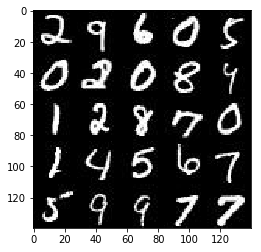

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

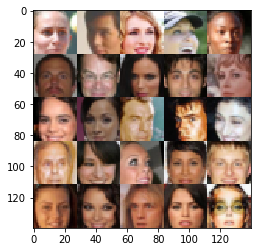

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate=tf.placeholder(tf.float32,name="learning_rate")
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [ ]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        #fc0 = tf.layers.dense(flat, 100,activation=tf.nn.relu)
        #fc1 = tf.layers.dense(fc0, 10,activation=tf.nn.relu)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [ ]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
                
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [ ]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [ ]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    #for var in t_vars:
    #    print(var.name)

    # Optimize
    #using this you need to feed input_real in the freed_dict of g_train_opt in train function
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    #    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    #    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    show_every=1000
    print_every=100
    steps=0
    out_channel_dim= 3 if data_image_mode=="RGB" else 1
    image_width, image_height, image_channels=(data_shape[1], data_shape[2], data_shape[3])
    input_real, input_z, ph_learning_rate=model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss=model_loss(input_real, input_z, out_channel_dim)
    d_opt,g_opt=model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                batch_images*=2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8271... Generator Loss: 0.3954
Epoch 1/2... Discriminator Loss: 1.4665... Generator Loss: 0.5174
Epoch 1/2... Discriminator Loss: 1.5858... Generator Loss: 0.4208
Epoch 1/2... Discriminator Loss: 1.0902... Generator Loss: 0.8504
Epoch 1/2... Discriminator Loss: 1.2448... Generator Loss: 0.6824
Epoch 1/2... Discriminator Loss: 1.2735... Generator Loss: 0.9574
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.7863
Epoch 1/2... Discriminator Loss: 1.3172... Generator Loss: 0.5488
Epoch 1/2... Discriminator Loss: 1.0724... Generator Loss: 0.8768
Epoch 1/2... Discriminator Loss: 1.2348... Generator Loss: 0.8246


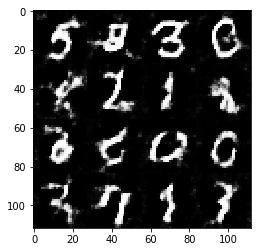

Epoch 1/2... Discriminator Loss: 0.9961... Generator Loss: 1.2789
Epoch 1/2... Discriminator Loss: 0.9085... Generator Loss: 1.1681
Epoch 1/2... Discriminator Loss: 0.8378... Generator Loss: 1.4979
Epoch 1/2... Discriminator Loss: 1.1272... Generator Loss: 0.9923
Epoch 1/2... Discriminator Loss: 1.3398... Generator Loss: 0.5404
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.7195
Epoch 1/2... Discriminator Loss: 1.2388... Generator Loss: 0.6393
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 0.9534
Epoch 1/2... Discriminator Loss: 1.1750... Generator Loss: 0.7515
Epoch 1/2... Discriminator Loss: 0.7828... Generator Loss: 1.4046


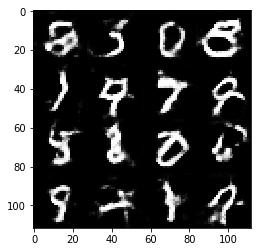

Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 1.0682
Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 0.8330
Epoch 1/2... Discriminator Loss: 1.0032... Generator Loss: 1.1577
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 0.8517
Epoch 1/2... Discriminator Loss: 0.8432... Generator Loss: 1.1905
Epoch 1/2... Discriminator Loss: 1.1669... Generator Loss: 0.9591
Epoch 1/2... Discriminator Loss: 0.8876... Generator Loss: 1.1289
Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 1.1877
Epoch 1/2... Discriminator Loss: 1.0805... Generator Loss: 0.9042
Epoch 1/2... Discriminator Loss: 1.0363... Generator Loss: 0.7781


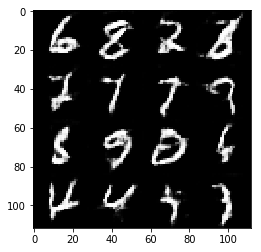

Epoch 1/2... Discriminator Loss: 1.2716... Generator Loss: 0.7479
Epoch 1/2... Discriminator Loss: 0.8876... Generator Loss: 1.1956
Epoch 1/2... Discriminator Loss: 0.9627... Generator Loss: 0.9054
Epoch 1/2... Discriminator Loss: 1.1108... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 1.4337... Generator Loss: 0.5175
Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 0.8544
Epoch 1/2... Discriminator Loss: 0.9421... Generator Loss: 0.9160
Epoch 1/2... Discriminator Loss: 1.1772... Generator Loss: 0.7034
Epoch 1/2... Discriminator Loss: 0.9265... Generator Loss: 1.0869
Epoch 1/2... Discriminator Loss: 0.7787... Generator Loss: 1.5768


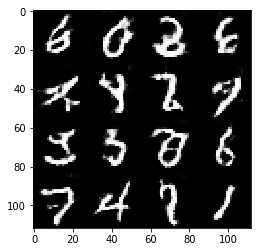

Epoch 1/2... Discriminator Loss: 0.9799... Generator Loss: 0.8951
Epoch 1/2... Discriminator Loss: 1.1256... Generator Loss: 0.7425
Epoch 1/2... Discriminator Loss: 0.9069... Generator Loss: 1.1770
Epoch 1/2... Discriminator Loss: 0.9147... Generator Loss: 0.9739
Epoch 1/2... Discriminator Loss: 0.8739... Generator Loss: 1.1293
Epoch 1/2... Discriminator Loss: 1.3835... Generator Loss: 1.1420
Epoch 1/2... Discriminator Loss: 0.9464... Generator Loss: 1.0404
Epoch 1/2... Discriminator Loss: 0.7429... Generator Loss: 1.4091
Epoch 1/2... Discriminator Loss: 0.9669... Generator Loss: 1.0212
Epoch 1/2... Discriminator Loss: 0.6982... Generator Loss: 1.3873


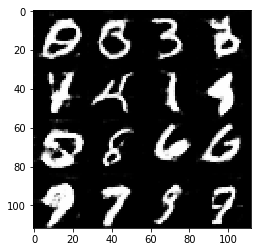

Epoch 1/2... Discriminator Loss: 1.4342... Generator Loss: 0.5025
Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 0.7146
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 1.1229
Epoch 1/2... Discriminator Loss: 1.0673... Generator Loss: 0.7556
Epoch 1/2... Discriminator Loss: 1.5220... Generator Loss: 0.4194
Epoch 1/2... Discriminator Loss: 1.2216... Generator Loss: 0.9017
Epoch 1/2... Discriminator Loss: 0.8653... Generator Loss: 1.0643
Epoch 1/2... Discriminator Loss: 0.9052... Generator Loss: 1.0619
Epoch 1/2... Discriminator Loss: 0.9121... Generator Loss: 0.9879
Epoch 1/2... Discriminator Loss: 0.9996... Generator Loss: 0.9760


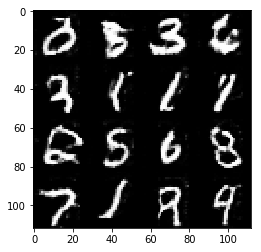

Epoch 1/2... Discriminator Loss: 0.8671... Generator Loss: 1.0833
Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 0.5214
Epoch 1/2... Discriminator Loss: 0.9354... Generator Loss: 1.1717
Epoch 1/2... Discriminator Loss: 0.9065... Generator Loss: 1.1254
Epoch 1/2... Discriminator Loss: 1.3566... Generator Loss: 0.5620
Epoch 1/2... Discriminator Loss: 1.0351... Generator Loss: 0.7803
Epoch 1/2... Discriminator Loss: 1.0903... Generator Loss: 0.7798
Epoch 1/2... Discriminator Loss: 0.8895... Generator Loss: 1.0695
Epoch 1/2... Discriminator Loss: 1.0240... Generator Loss: 0.8388
Epoch 1/2... Discriminator Loss: 0.9653... Generator Loss: 0.8589


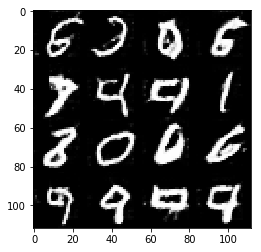

Epoch 1/2... Discriminator Loss: 0.6321... Generator Loss: 1.7401
Epoch 1/2... Discriminator Loss: 1.3552... Generator Loss: 0.5745
Epoch 1/2... Discriminator Loss: 1.1581... Generator Loss: 0.7908
Epoch 1/2... Discriminator Loss: 0.9850... Generator Loss: 0.9344
Epoch 1/2... Discriminator Loss: 0.9384... Generator Loss: 1.1854
Epoch 2/2... Discriminator Loss: 0.9485... Generator Loss: 1.0080
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 1.0254
Epoch 2/2... Discriminator Loss: 0.6840... Generator Loss: 1.5017
Epoch 2/2... Discriminator Loss: 0.7860... Generator Loss: 1.2181
Epoch 2/2... Discriminator Loss: 1.5458... Generator Loss: 0.4981


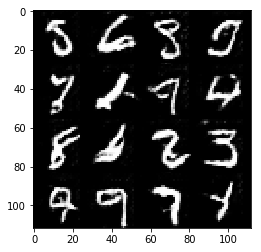

Epoch 2/2... Discriminator Loss: 0.7072... Generator Loss: 1.3771
Epoch 2/2... Discriminator Loss: 1.0690... Generator Loss: 0.9047
Epoch 2/2... Discriminator Loss: 1.0139... Generator Loss: 0.8518
Epoch 2/2... Discriminator Loss: 1.1127... Generator Loss: 0.7522
Epoch 2/2... Discriminator Loss: 0.9960... Generator Loss: 0.8643
Epoch 2/2... Discriminator Loss: 0.7830... Generator Loss: 1.1924
Epoch 2/2... Discriminator Loss: 1.0392... Generator Loss: 1.0479
Epoch 2/2... Discriminator Loss: 0.7051... Generator Loss: 1.3730
Epoch 2/2... Discriminator Loss: 0.6857... Generator Loss: 1.4394
Epoch 2/2... Discriminator Loss: 0.8394... Generator Loss: 1.0289


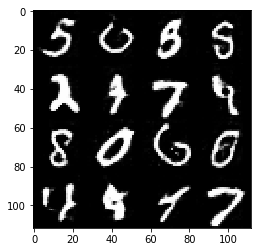

Epoch 2/2... Discriminator Loss: 1.0466... Generator Loss: 0.8642
Epoch 2/2... Discriminator Loss: 1.2531... Generator Loss: 0.6890
Epoch 2/2... Discriminator Loss: 1.0863... Generator Loss: 0.8651
Epoch 2/2... Discriminator Loss: 0.8236... Generator Loss: 1.2017
Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 0.6153
Epoch 2/2... Discriminator Loss: 1.0932... Generator Loss: 0.8126
Epoch 2/2... Discriminator Loss: 1.2413... Generator Loss: 0.6294
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 0.8898
Epoch 2/2... Discriminator Loss: 0.8274... Generator Loss: 1.0662
Epoch 2/2... Discriminator Loss: 0.7343... Generator Loss: 1.5692


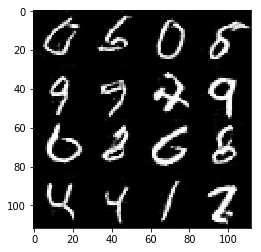

Epoch 2/2... Discriminator Loss: 1.0259... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 1.0871... Generator Loss: 0.8065
Epoch 2/2... Discriminator Loss: 0.7727... Generator Loss: 1.3337
Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 0.9134
Epoch 2/2... Discriminator Loss: 0.9488... Generator Loss: 1.0786
Epoch 2/2... Discriminator Loss: 0.9083... Generator Loss: 1.0231
Epoch 2/2... Discriminator Loss: 1.1128... Generator Loss: 0.7285
Epoch 2/2... Discriminator Loss: 1.0817... Generator Loss: 0.9092
Epoch 2/2... Discriminator Loss: 0.9784... Generator Loss: 0.8640
Epoch 2/2... Discriminator Loss: 0.9431... Generator Loss: 0.9787


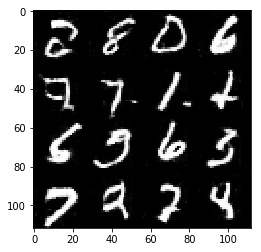

Epoch 2/2... Discriminator Loss: 0.9552... Generator Loss: 0.8986
Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 0.9983
Epoch 2/2... Discriminator Loss: 1.2796... Generator Loss: 0.5846
Epoch 2/2... Discriminator Loss: 0.8978... Generator Loss: 0.9252
Epoch 2/2... Discriminator Loss: 0.7942... Generator Loss: 1.1201
Epoch 2/2... Discriminator Loss: 0.5962... Generator Loss: 1.8003
Epoch 2/2... Discriminator Loss: 1.0928... Generator Loss: 0.7441
Epoch 2/2... Discriminator Loss: 1.0301... Generator Loss: 0.8291
Epoch 2/2... Discriminator Loss: 0.8649... Generator Loss: 1.0274
Epoch 2/2... Discriminator Loss: 0.8977... Generator Loss: 0.9856


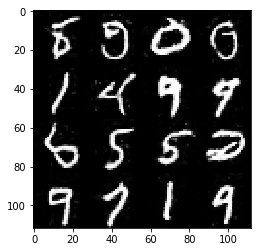

Epoch 2/2... Discriminator Loss: 0.8840... Generator Loss: 0.9948
Epoch 2/2... Discriminator Loss: 0.6835... Generator Loss: 1.7254
Epoch 2/2... Discriminator Loss: 0.9589... Generator Loss: 0.8916
Epoch 2/2... Discriminator Loss: 0.8825... Generator Loss: 1.1235
Epoch 2/2... Discriminator Loss: 0.7123... Generator Loss: 1.4211
Epoch 2/2... Discriminator Loss: 0.9703... Generator Loss: 0.8776
Epoch 2/2... Discriminator Loss: 0.8370... Generator Loss: 1.1959
Epoch 2/2... Discriminator Loss: 1.0444... Generator Loss: 0.8743
Epoch 2/2... Discriminator Loss: 1.0551... Generator Loss: 0.7709
Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.5588


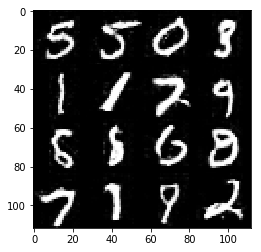

Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 0.9730
Epoch 2/2... Discriminator Loss: 1.4809... Generator Loss: 0.5116
Epoch 2/2... Discriminator Loss: 0.5508... Generator Loss: 1.8724
Epoch 2/2... Discriminator Loss: 0.7647... Generator Loss: 1.2654
Epoch 2/2... Discriminator Loss: 0.9896... Generator Loss: 1.1114
Epoch 2/2... Discriminator Loss: 0.7024... Generator Loss: 1.4464
Epoch 2/2... Discriminator Loss: 1.1186... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 0.8148... Generator Loss: 1.1813
Epoch 2/2... Discriminator Loss: 1.0766... Generator Loss: 0.8125
Epoch 2/2... Discriminator Loss: 1.4811... Generator Loss: 0.4521


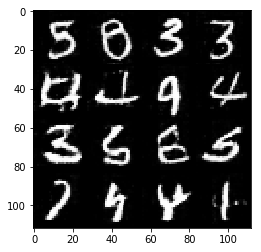

Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.5710
Epoch 2/2... Discriminator Loss: 1.0527... Generator Loss: 0.8767
Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 1.0195
Epoch 2/2... Discriminator Loss: 0.7620... Generator Loss: 1.2246
Epoch 2/2... Discriminator Loss: 0.9103... Generator Loss: 1.0407
Epoch 2/2... Discriminator Loss: 0.6531... Generator Loss: 2.0007
Epoch 2/2... Discriminator Loss: 0.8729... Generator Loss: 1.1285
Epoch 2/2... Discriminator Loss: 0.7648... Generator Loss: 1.3575
Epoch 2/2... Discriminator Loss: 1.2868... Generator Loss: 0.7192
Epoch 2/2... Discriminator Loss: 0.6670... Generator Loss: 1.5720


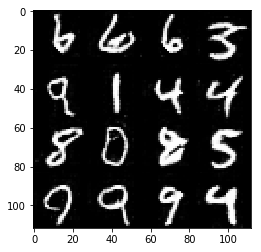

In [33]:
batch_size = 8
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.4022
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 0.5373... Generator Loss: 2.3863
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.4841
Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 3.2802
Epoch 1/1... Discriminator Loss: 0.7050... Generator Loss: 1.5696
Epoch 1/1... Discriminator Loss: 0.5117... Generator Loss: 2.6822
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 0.5349... Generator Loss: 1.8882


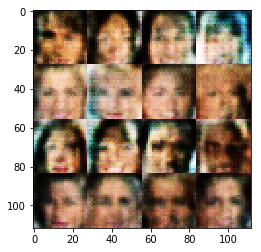

Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 1.8049
Epoch 1/1... Discriminator Loss: 2.0791... Generator Loss: 0.2236
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 4.3928
Epoch 1/1... Discriminator Loss: 0.5721... Generator Loss: 1.9468
Epoch 1/1... Discriminator Loss: 0.4269... Generator Loss: 4.6760
Epoch 1/1... Discriminator Loss: 0.4991... Generator Loss: 2.6654
Epoch 1/1... Discriminator Loss: 0.4601... Generator Loss: 2.2603
Epoch 1/1... Discriminator Loss: 0.6741... Generator Loss: 1.6726
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 0.8757


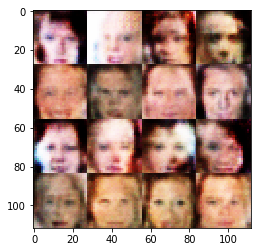

Epoch 1/1... Discriminator Loss: 0.3732... Generator Loss: 4.1771
Epoch 1/1... Discriminator Loss: 0.3674... Generator Loss: 6.1276
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 2.3982
Epoch 1/1... Discriminator Loss: 0.5390... Generator Loss: 2.0152
Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.1511
Epoch 1/1... Discriminator Loss: 0.4966... Generator Loss: 2.2004
Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 4.2646
Epoch 1/1... Discriminator Loss: 0.5042... Generator Loss: 2.0053
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.8658


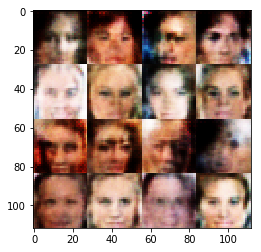

Epoch 1/1... Discriminator Loss: 1.7842... Generator Loss: 0.3195
Epoch 1/1... Discriminator Loss: 1.6472... Generator Loss: 1.7511
Epoch 1/1... Discriminator Loss: 0.4904... Generator Loss: 2.2311
Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 1.9063
Epoch 1/1... Discriminator Loss: 0.3837... Generator Loss: 3.8831
Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 5.1702
Epoch 1/1... Discriminator Loss: 0.9301... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 2.4083
Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 1.1170
Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 2.0680


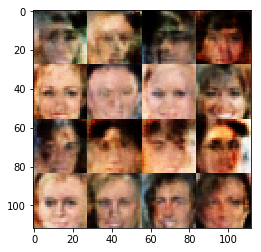

Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 1.3169
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 2.1644
Epoch 1/1... Discriminator Loss: 0.3752... Generator Loss: 4.1402
Epoch 1/1... Discriminator Loss: 0.4512... Generator Loss: 2.4289
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 1.7107
Epoch 1/1... Discriminator Loss: 1.8864... Generator Loss: 0.2767
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 0.5715... Generator Loss: 1.6156
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 1.6182


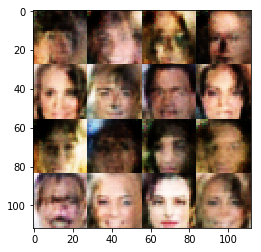

Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 2.5550
Epoch 1/1... Discriminator Loss: 0.5486... Generator Loss: 1.9089
Epoch 1/1... Discriminator Loss: 0.4610... Generator Loss: 3.3082
Epoch 1/1... Discriminator Loss: 1.9556... Generator Loss: 0.3765
Epoch 1/1... Discriminator Loss: 0.6428... Generator Loss: 1.5464
Epoch 1/1... Discriminator Loss: 0.3783... Generator Loss: 4.6241
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 1.7031
Epoch 1/1... Discriminator Loss: 0.4514... Generator Loss: 2.7496
Epoch 1/1... Discriminator Loss: 0.4395... Generator Loss: 4.0898
Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 2.4830


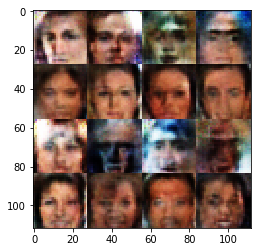

Epoch 1/1... Discriminator Loss: 0.4090... Generator Loss: 3.1679
Epoch 1/1... Discriminator Loss: 0.4422... Generator Loss: 2.9850
Epoch 1/1... Discriminator Loss: 0.5970... Generator Loss: 1.6535
Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 1.1181
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 1.0846
Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 1.2731
Epoch 1/1... Discriminator Loss: 0.6489... Generator Loss: 1.6752
Epoch 1/1... Discriminator Loss: 0.4238... Generator Loss: 2.7631


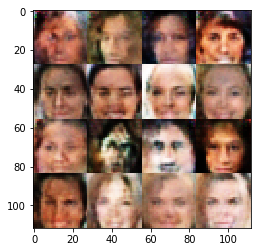

Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 1.2721
Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 1.3752
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.4423
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 1.2657
Epoch 1/1... Discriminator Loss: 0.6012... Generator Loss: 1.7419
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 2.0993
Epoch 1/1... Discriminator Loss: 0.5175... Generator Loss: 2.4235


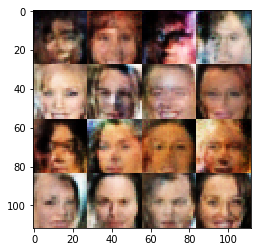

Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 1.2736
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 1.0659
Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 1.5182
Epoch 1/1... Discriminator Loss: 0.4896... Generator Loss: 2.0426
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 1.7854
Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 2.4877
Epoch 1/1... Discriminator Loss: 0.4332... Generator Loss: 2.6226
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 1.0033
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 0.9583


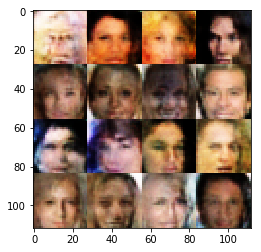

Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 1.0849
Epoch 1/1... Discriminator Loss: 0.5456... Generator Loss: 1.7236
Epoch 1/1... Discriminator Loss: 0.4403... Generator Loss: 2.5982
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.2527
Epoch 1/1... Discriminator Loss: 0.7455... Generator Loss: 1.3455
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 0.6814... Generator Loss: 1.4359
Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 1.6166
Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 1.3649


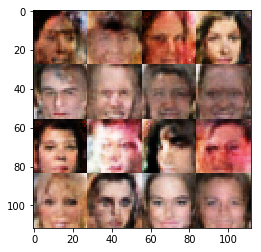

Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 0.4792... Generator Loss: 2.5949
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 2.1813
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 1.5600
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 0.4415... Generator Loss: 2.6355
Epoch 1/1... Discriminator Loss: 0.6134... Generator Loss: 1.7259


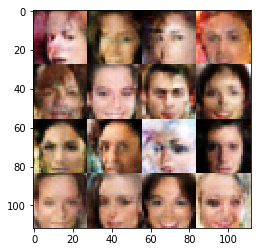

Epoch 1/1... Discriminator Loss: 0.5351... Generator Loss: 2.0737
Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 2.0918
Epoch 1/1... Discriminator Loss: 0.5470... Generator Loss: 2.0086
Epoch 1/1... Discriminator Loss: 0.8072... Generator Loss: 1.1899
Epoch 1/1... Discriminator Loss: 0.4080... Generator Loss: 3.5879
Epoch 1/1... Discriminator Loss: 0.5841... Generator Loss: 1.7615
Epoch 1/1... Discriminator Loss: 0.4987... Generator Loss: 2.3505
Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 1.6219
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.1166


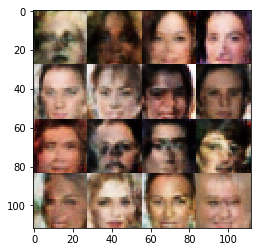

Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 0.8605... Generator Loss: 1.1131
Epoch 1/1... Discriminator Loss: 0.5973... Generator Loss: 1.8251
Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 2.9428
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.5006
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.5973


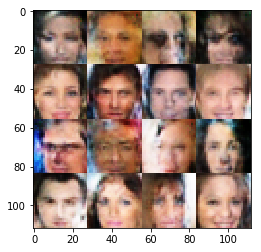

Epoch 1/1... Discriminator Loss: 0.4137... Generator Loss: 3.2526
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 1.3065
Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 1.3527
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 1.1310
Epoch 1/1... Discriminator Loss: 0.8575... Generator Loss: 1.2007
Epoch 1/1... Discriminator Loss: 0.5720... Generator Loss: 1.8791
Epoch 1/1... Discriminator Loss: 0.4084... Generator Loss: 3.0000
Epoch 1/1... Discriminator Loss: 0.5008... Generator Loss: 2.8467
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 1.4527
Epoch 1/1... Discriminator Loss: 0.5404... Generator Loss: 2.0196


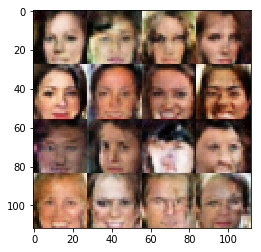

Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.4696
Epoch 1/1... Discriminator Loss: 0.8427... Generator Loss: 1.2066
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 0.7200... Generator Loss: 1.6145
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.4979


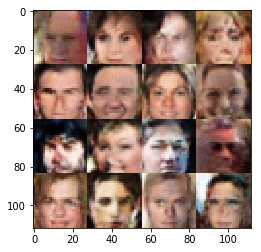

Epoch 1/1... Discriminator Loss: 0.6003... Generator Loss: 1.5381
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 0.5453... Generator Loss: 2.1024
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 0.4771... Generator Loss: 2.8869
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.5615... Generator Loss: 0.4021
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 1.5810... Generator Loss: 0.3967


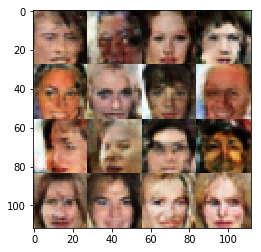

Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 1.4156
Epoch 1/1... Discriminator Loss: 0.5525... Generator Loss: 1.9341
Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 1.0340
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 1.5762... Generator Loss: 0.3892


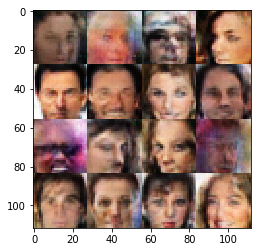

Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 1.7141
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 0.4808... Generator Loss: 2.3074
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.9151
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 1.2250
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 2.1071
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.9781
Epoch 1/1... Discriminator Loss: 0.7201... Generator Loss: 1.2721
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 0.8688


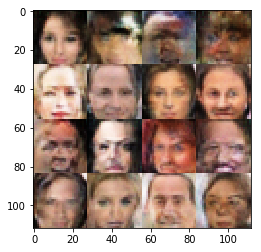

Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 2.8367
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 1.3957
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 0.6353... Generator Loss: 1.7272
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.4819


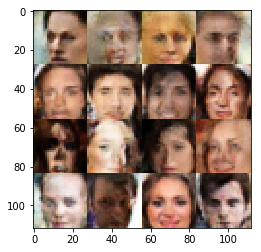

Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 0.5089... Generator Loss: 2.3330
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 2.0628
Epoch 1/1... Discriminator Loss: 0.8353... Generator Loss: 1.1191
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.4650
Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 1.1421
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 1.3757
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.0713


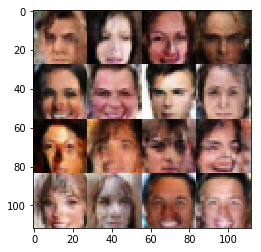

Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 1.3559
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 2.2424
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 1.5867
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 0.8663... Generator Loss: 1.1315
Epoch 1/1... Discriminator Loss: 0.7422... Generator Loss: 1.5210


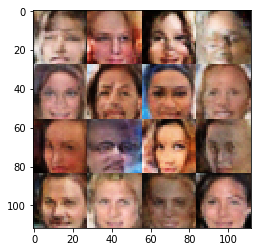

Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.4726
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 1.1617
Epoch 1/1... Discriminator Loss: 0.6684... Generator Loss: 1.6091
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 0.6114... Generator Loss: 1.6196
Epoch 1/1... Discriminator Loss: 0.6388... Generator Loss: 1.4648


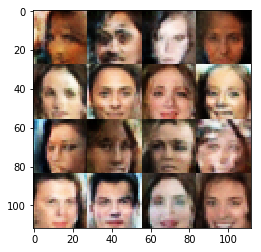

Epoch 1/1... Discriminator Loss: 0.8828... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 1.3446
Epoch 1/1... Discriminator Loss: 0.7844... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 1.3751
Epoch 1/1... Discriminator Loss: 0.6074... Generator Loss: 1.7675
Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 0.8218... Generator Loss: 1.1179
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.0996
Epoch 1/1... Discriminator Loss: 0.8221... Generator Loss: 1.1438


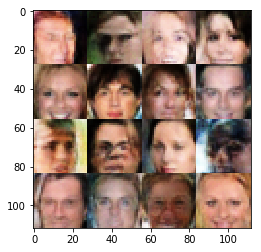

Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 1.0776
Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 1.5497
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 1.3676
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 0.4719... Generator Loss: 2.6234


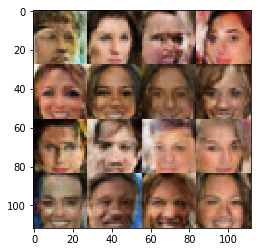

Epoch 1/1... Discriminator Loss: 0.7306... Generator Loss: 1.2898
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 0.7905... Generator Loss: 1.2423
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 0.4889... Generator Loss: 2.3928
Epoch 1/1... Discriminator Loss: 0.5676... Generator Loss: 2.6604
Epoch 1/1... Discriminator Loss: 0.5555... Generator Loss: 1.7629
Epoch 1/1... Discriminator Loss: 0.5223... Generator Loss: 2.2394
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 0.8969


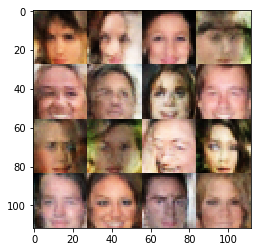

Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.5042


In [35]:
batch_size = 8
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.